Compute the detected period error of the BLS fit to the simulated injected planet signals and primary koi signals. This criteria will be used to select which signals should be labed as false for the model.  

In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize, fmin, fminbound, fmin_slsqp, brute

In [2]:
injected_sigs = np.loadtxt("../../../Training/simulation/injection/injection.txt", dtype=str, delimiter=",")
#injected_sigs = np.loadtxt("../Catalogs/injection.txt", dtype=str, delimiter=",")

periods_inj = injected_sigs[:, 3].astype("float64")
SNR = np.loadtxt("../Data/SNR_10000_corrected.txt")[:10000]

In [3]:
values = np.core.defchararray.add(injected_sigs[:,0], "-")
values = np.core.defchararray.add(values, injected_sigs[:, 1])
values = np.core.defchararray.add(values, "_inj.blsanal")
values

array(['10000198-0_inj.blsanal', '10000198-1_inj.blsanal',
       '10000198-2_inj.blsanal', ..., '9999901-13_inj.blsanal',
       '9999901-14_inj.blsanal', '9999901-15_inj.blsanal'], 
      dtype='|S51')

In [4]:
#Get the detected bls periods for the injected signals for the first 10000 signals

periods_bls = np.zeros(10000)# []
for i, name in enumerate(values[:10000]):
    periods_bls[i]=np.loadtxt("../../../Training/simulation/injection/" + name)[0,1]
    if i % 1000 ==999:
        print i

999
1999
2999
3999
4999
5999
6999
7999
8999
9999


In [5]:
#
#harmonics = np.loadtxt("../Data/period_harmonics_10000_inj_signals.txt")

In [6]:
def period_func(vals, p_bls, p_inj):
    a, b = vals
    a = np.rint(a)
    b = np.rint(b)
    #print a, b
    #print a*p_bls-b*p_inj
    
    return np.abs((a*p_bls - b*p_inj) / 0.5/(a*p_bls + b*p_inj))

In [7]:
rranges = (slice(1,6, 1), slice(1,6, 1))
harmonics = np.empty(shape = [10000,2])
for i in range(10000):
    results = brute(period_func, ranges=rranges, args=(periods_bls[i], periods_inj[i]), full_output=True, finish= None)
    harmonics[i, :] =results[0]
    try:
        results[0].astype(int)
    except:
        print i
print harmonics.shape

(10000, 2)


2073
8023


(array([  9.57100000e+03,   1.33000000e+02,   4.80000000e+01,
          3.80000000e+01,   2.30000000e+01,   3.30000000e+01,
          1.70000000e+01,   3.30000000e+01,   2.00000000e+01,
          2.00000000e+01,   2.00000000e+01,   1.60000000e+01,
          1.70000000e+01,   9.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([ 0.        ,  0.10526316,  0.21052632,  0.31578947,  0.42105263,
         0.52631579,  0.63157895,  0.73684211,  0.84210526,  0.94736842,
         1.05263158,  1.15789474,  1.26315789,  1.36842105,  1.47368421,
         1.57894737,  1.68421053,  1.78947368,  1.89473684,  2.        ]),
 <a list of 19 Patch objects>)

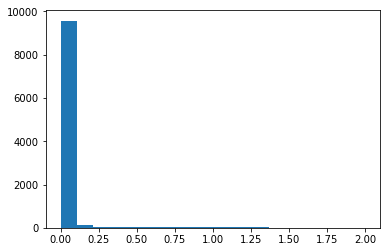

In [8]:
tol = np.zeros(10000)
for i in range(10000):
    tol[i] = period_func( harmonics[i], periods_bls[i], periods_inj[i])
print len(np.where(tol>0.0015)[0])
print len(np.unique(np.where(harmonics>1)[0]))
plt.hist(tol, bins = np.linspace(0,2,20))

In [9]:
print harmonics.shape, tol.shape
tot_vals = np.hstack([harmonics, tol.reshape(10000,1)])
print tot_vals.shape

(10000, 2) (10000,)
(10000, 3)


In [10]:
np.savetxt("period_harmonics_10000_inj_signals_tol.txt",tot_vals)

In [11]:
harmonics = np.rint(harmonics)
print harmonics[SNR<6]

[[ 1.  4.]
 [ 2.  1.]
 [ 5.  3.]
 ..., 
 [ 5.  1.]
 [ 5.  1.]
 [ 5.  1.]]


Now we will generate the KOI period error distribution

In [12]:
koi_feats=  pd.read_csv("../Data/KOI_feat_files_3080_fixed_ordered_try2.csv", index_col=0)
koi_feats.head()

,mod_sig_pri_dv,mod_sig_sec_dv,mod_sig_ter_dv,mod_sig_pos_dv,mod_fa1_dv,mod_fa2_dv,mod_fred_dv,modshiftval1_dv,modshiftval2_dv,modshiftval3_dv,...,BLS_i2_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Npointsintransit_1_0,BLS_Ntransits_1_0,BLS_Npointsbeforetransit_1_0,BLS_Npointsaftertransit_1_0,BLS_Rednoise_1_0,BLS_Whitenoise_1_0,BLS_SignaltoPinknoise_1_0
0,0.00010,-9.993175,0.006914,-0.000487,2.890723,1.683670,1.005397,-2.890624,-1.690483,-1.683083,...,0.96101,-0.0,0.14202,133.0,24.0,148.0,134.0,0.00004,0.00017,5.83681
1,0.00018,-9.982177,0.017533,-0.014838,3.338459,3.020050,0.252293,-3.337746,-3.037403,-3.005032,...,0.05055,-0.0,0.88621,51.0,3.0,47.0,50.0,0.00001,0.00018,6.80030
2,0.00015,-9.989170,0.009608,-0.008737,3.180644,2.974051,0.464413,-3.180321,-2.983509,-2.965164,...,0.97089,-0.0,0.43709,48.0,2.0,53.0,54.0,0.00000,0.00015,7.04246
3,0.00010,-9.996074,0.002071,-0.019393,2.881972,2.019152,0.993675,-2.881872,-2.021124,-1.999660,...,0.43575,-0.0,0.14349,140.0,11.0,147.0,140.0,0.00003,0.00016,6.21358
4,0.00025,-9.976817,0.021595,-0.020386,3.253059,3.050659,0.153960,-3.251435,-3.072004,-3.030023,...,0.97488,-0.0,0.80420,35.0,2.0,38.0,41.0,0.00002,0.00020,6.96992


In [13]:
file_name = '../../../Training/catalogs/shortperiodbright_KOI.csv'
#file_name = pd.read_csv("../Catalogs/shortperiodbright_KOI.csv")
koi = pd.read_csv(file_name)
#print koi.columns.values
file_list = os.listdir("../KOI_ModShiftVals_Try2/.")

star_name = koi["kepid"]
periods = koi["koi_period"]
data  = np.loadtxt(file_name, dtype = str, delimiter=",")#.reshape(data.shape[0], 5)
inds = np.where(koi["koi_model_snr"]==np.nan)[0]
koi["koi_model_snr"][inds]==1000.
values = np.core.defchararray.add(data[:,0], "-")
values = np.core.defchararray.add(values, data[:, 1])


planet_periods = np.zeros(koi_feats.shape[0])

#print data.shape
start  = time.time

# create KOI lc file with p rad, s rad,period,  duration
for i, val in enumerate(file_list):
    name = int(val.split("-")[0])
    file_name = (val.split("-")[0]) + "-"+(val.split("-")[1]).split("_")[0]

    if name in star_name.tolist():
        location = np.where(star_name== int(name))[0]
        #planet_num = 0
        if len(location) > 1: 
            #this is if the star has more than one planets, select the one with the highest SNR
            planet_num = np.where(koi["koi_model_snr"][location].max() == koi["koi_model_snr"][location])[0]
            location =   np.where(star_name== int(name))[0][planet_num]
        else:
            location = np.where(star_name== int(name))[0][0]
        try:
            planet_periods[i] = koi["koi_period"][location] #days         
        except:
            print name

    else:
        print "Not in list", val[:-17]#+"ltf.lc"
    if i %1000 ==999:
        print i


999
1999
2999


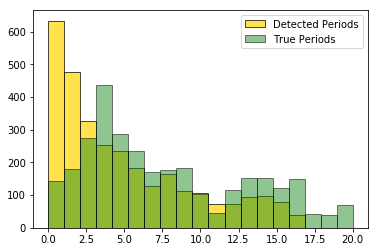

In [45]:
bins = np.linspace(0, 20, 20)
fig = plt.figure()
ax = fig.add_subplot("111")
plt.hist(koi_feats["BLS_Period_1_0"], bins = bins,  alpha = 0.7 , label = "Detected Periods", color = "gold", edgecolor = "black")
plt.hist(planet_periods, bins = bins,  alpha = 0.5, label = "True Periods", color = "forestgreen", edgecolor = "black")
plt.legend()

In [46]:
harmonics_koi = np.empty(shape = [koi_feats.shape[0],2])
for i in range(koi_feats.shape[0]):
  
    results = brute(period_func, ranges=rranges, args=(koi_feats["BLS_Period_1_0"][i], planet_periods[i]), full_output=True, finish= None)
    harmonics_koi[i, :] =results[0]
    try:
        results[0].astype(int)
    except:
        print i
print harmonics_koi.shape

(3080, 2)


1122
2818


(0, 0.02)

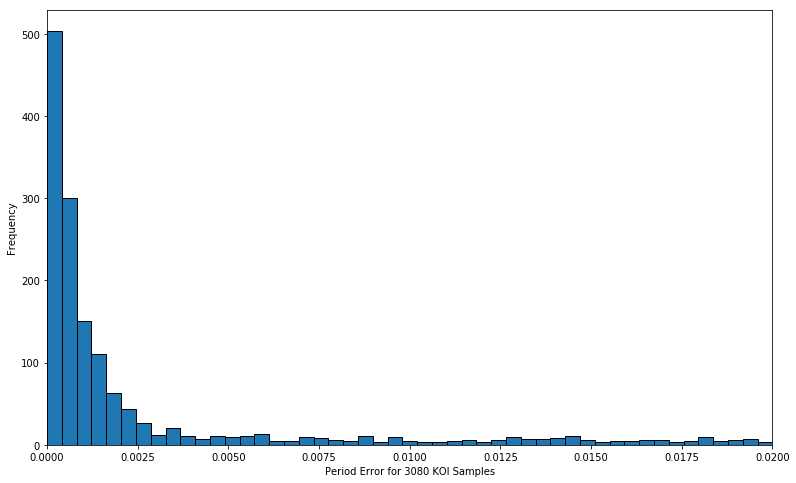

In [16]:
tol_koi = np.zeros(koi_feats.shape[0])
for i in range(koi_feats.shape[0]):
    tol_koi[i] = period_func( harmonics_koi[i], koi_feats["BLS_Period_1_0"][i], planet_periods[i])

print len(np.where(tol_koi<0.002)[0])
print len(np.unique(np.where(harmonics_koi>1)[0]))
plt.figure(figsize=(13, 8))
plt.hist(tol_koi, bins = np.linspace(0,0.02,50), edgecolor = "black")
tot_vals_koi = np.hstack([harmonics_koi, tol_koi.reshape(harmonics_koi.shape[0], 1)]) 
plt.ylabel("Frequency")
plt.xlabel("Period Error for 3080 KOI Samples")
plt.xlim([0,0.02])

In [69]:
print tot_vals_koi.shape
np.savetxt("period_harmonics_3080_koi_signals_tol.txt", tot_vals_koi)

(3080, 3)
